## ML for simple input features

### Problem
One of the typical challenges in ML is feature selection: Which features will be used characterize the input samples and train the models? The features should be representative, contain sufficient information for the model to be able to make an informed decision, but should also avoid redundancy or useless information. Therefore, traditional features for NIDS include:

- The IPv4 source and destination addresses;
- The TCP source and destination ports;
- Statistics on the number of packets/bytes in a network flow (count, average, STD, duration, ...);
- Network flags (e.g. TCP flags);
- ...

Typically, these features are provided alongside the raw network traffic data in a dataset. Most ML and DL models therefor use those features for training models, obtaining excellent results. This approach however has some considerable drawbacks:

- Different datasets provide different features, complicating inter-dataset comparison;
- Extracting these features requires significant preprocessing of raw traffic data.

While the first point is more of a general concern, the second is especially relevant when dealing with hardware: When dealing with high-speed real-time network traffic, there are only limited resources available for dealing with feature extraction. This calls for either optimized routines to extract a limited number of specific features, or for an alternative.


### Alternative: Raw traffic-based features
One alternative is to use the raw input traffic itself as features, instead of deriving the features from the traffic: We call such features *raw traffic-based features* (RTF). This is what we will do in this notebook.

While using RTF in some sense limits the amount of possible features, there are still three choices to be made:
- What packet bytes to use;
- How many packet bytes to use;
- How many packets to use.

In this exercise, we will use the first 64 bytes of each individual packet as input features. That includes the header, as well as potentially a small part of the payload. Using 64B input features therefore should provide all header information about the network flow: Source and destination information, protocol information (including flags), packet size, ... We leave the DL model to parse and use this information to its own liking. Moreover, choosing specifically 64B for input features provides several other advantages:

- 64 bytes is relatively small, limiting the required hardware resources;
- 64 bytes is a very convenient number of bytes to work with on a hardware level.

#### Raw traffic-based features on hardware
One major advantage of RTF over traditional NIDS features is that they are very easy to extract in real-time on hardware. Instead of having to design intricate counting and parsing architectures, all you need to start collecting RTF is a buffer. Simply storing the required amount of packet bytes in the buffer effectively provides the features.

#### Raw traffic-based features in software
Simulating this behaviour in software requires a chronological iteration over the dataset, while extracting the first 64 bytes from each packet, and storing them in a buffer.

For this exercise, we will extract input samples from the CICIDS2017 dataset: While the dataset contains several protocols, such as ARP and ICMP, we are only interested in **TCP and UDP** packets. The trained model we will be using later on is only trained for those transport layer protocols.

In [47]:
import torch
import numpy as np
from lib.dataset import NIDSDataset


# Initialize the dataset
dset = NIDSDataset(
    packets_file="./data/dataset_packets_v2.npy", 
    labels_file="./data/dataset_labels_v1.npy")

# The input_buffer contains all input features
input_buffer = []
label_buffer = []

# Iterate over the dataset, and add all valid input features to the buffer
# Accordingly, also extract the label for each of those packets and save it as well

for packet in dset:
    label = packet.get_label()
    input_sample = np.zeros(64)
    
    # For each valid packet, extract the features to the input_sample and append the input_sample to the 
    # input_buffer. Do not forget the labels!
    # Your code starts here

    
    
print("We extracted {} input samples.".format(len(input_buffer)))
print("We extracted {} labels.".format(len(label_buffer)))

We extracted 1200 input samples.
We extracted 1200 labels.


For use in PyTorch, we need to present the input samples as *tensors*. Additionally, the input dimensionality needs to be slightly changed to be suitable for inference.

In [48]:
input_tensors = []

for input_sample in input_buffer:
    # Turn the Numpy array into a PyTorch tensor
    input_tensor = torch.from_numpy(input_sample)
    # Change input dimensionality
    input_tensor = input_tensor.view(1, 1, 64)
    
    input_tensors.append(input_tensor)

### Inference

Once we have extracted a set of input samples from the dataset, we can do inference on the neural network. For this excercise, we use a Convolutional Neural Network (CNN) with 1D convolutions that takes an input of size 64.

As the network has already been trained, we only need to load it from the storage:

In [49]:
from lib.nn_model import ExampleCNN1D1x64

model = ExampleCNN1D1x64(13)

# Load the trained parameters
model.load_state_dict(torch.load("./data/cnn1d1x64.model", map_location=torch.device('cpu')))

# Set the Batch Normalization layers for inference
model.eval()

ExampleCNN1D1x64(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer4): Sequential(
    (0): Conv1d(64, 96, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(96

The output of the above cell gives an overview of the used neural network. Finally, we can run the prepared input tensors through the CNN:

In [50]:
from lib.nn_model import label_mapping

predictions = []

for input_tensor in input_tensors:
    output_tensor = model(input_tensor.float())
    
    _, predicted = torch.max(output_tensor, 1)
    predictions.append(predicted)

predictions = torch.stack(predictions, 0).numpy()
print(predictions)

[[0]
 [0]
 [0]
 ...
 [3]
 [3]
 [3]]


The *predictions* list contains the class indices corresponding with the predictions. We can visualize the performance of these predictions using a *confusion matrix* (CM). The confusion matrix is a big matrix where each row represents the expected class, while the columns represent the predicted class. It gives a detailed overview of the detection performance for each class. For the visualization of the CM we use the *sklearn* and *matplotlib* packages. 

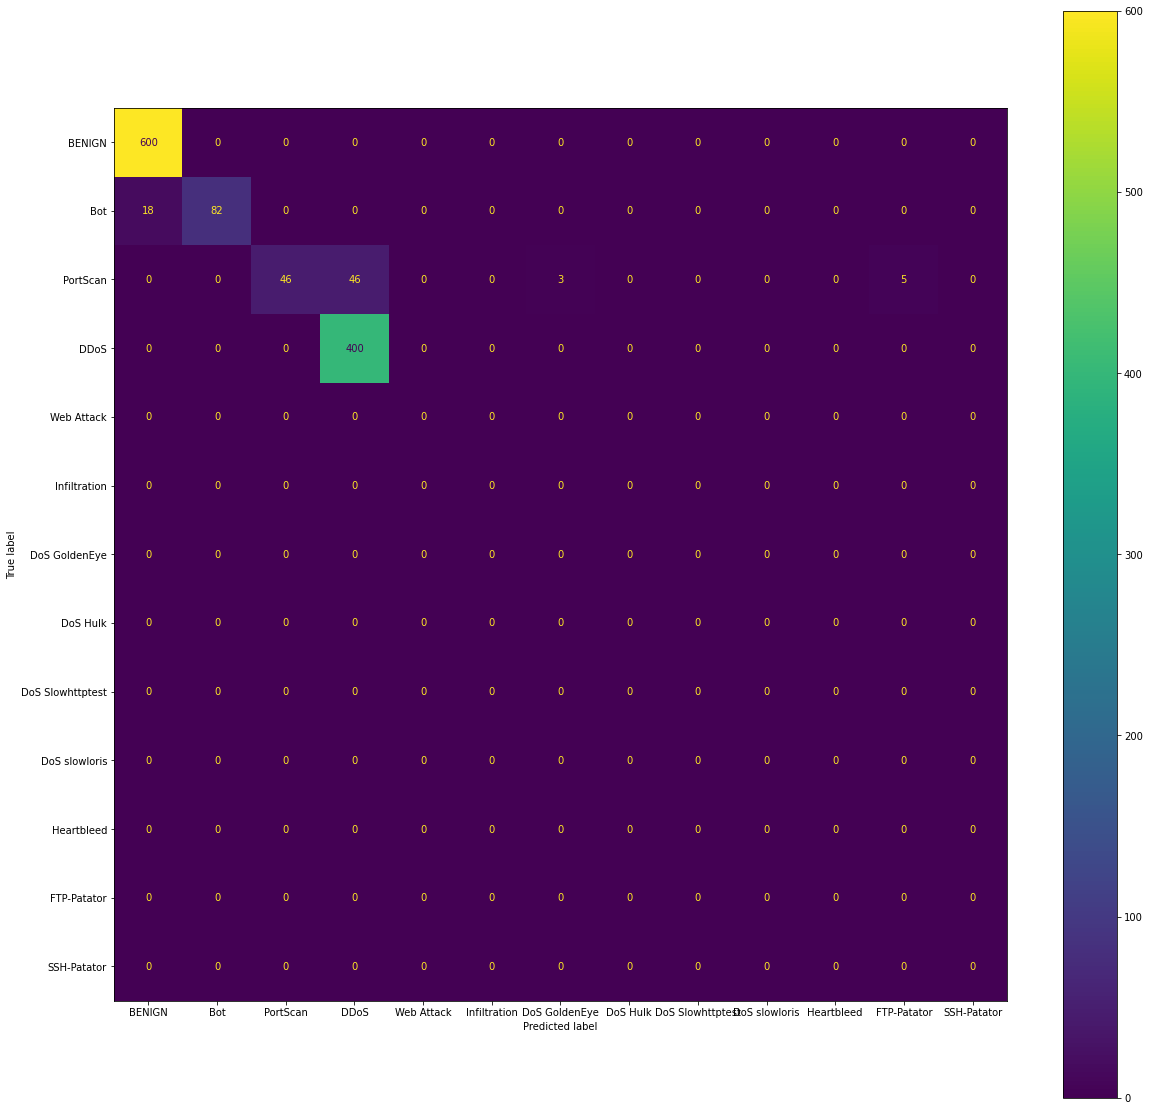

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Transform the indices to their corresponding class label:
labelled_predictions = []
for prediction in predictions:
    labelled_predictions.append(label_mapping[prediction[0]])

# Choose output figure size
_, ax = plt.subplots(figsize=(20, 20))

# Calculate the confusion matrix
cm = confusion_matrix(label_buffer, labelled_predictions, labels=label_mapping)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_mapping)
disp.plot(ax=ax)
plt.show()

Take a moment to consider your results, as well as their implications. Does the algorithm detect all attacks? Where does it go wrong? Why could that be the case? Would you entrust the security of your network to such an algorithm?

As a final step, calculate the classification report from sklearn:

In [53]:
from sklearn.metrics import classification_report

from sklearn.metrics import classification_report

print(classification_report(label_buffer, labelled_predictions, 
                            labels=label_mapping, 
                            target_names=label_mapping,
                            digits=4,
                            zero_division=0
                           ))

                  precision    recall  f1-score   support

          BENIGN     0.9709    1.0000    0.9852       600
             Bot     1.0000    0.8200    0.9011       100
        PortScan     1.0000    0.4600    0.6301       100
            DDoS     0.8969    1.0000    0.9456       400
      Web Attack     0.0000    0.0000    0.0000         0
    Infiltration     0.0000    0.0000    0.0000         0
   DoS GoldenEye     0.0000    0.0000    0.0000         0
        DoS Hulk     0.0000    0.0000    0.0000         0
DoS Slowhttptest     0.0000    0.0000    0.0000         0
   DoS slowloris     0.0000    0.0000    0.0000         0
      Heartbleed     0.0000    0.0000    0.0000         0
     FTP-Patator     0.0000    0.0000    0.0000         0
     SSH-Patator     0.0000    0.0000    0.0000         0

       micro avg     0.9400    0.9400    0.9400      1200
       macro avg     0.2975    0.2523    0.2663      1200
    weighted avg     0.9511    0.9400    0.9354      1200



We expect the following results:

- BENIGN F1 = 0.9852
- Bot F1 = 0.9011
- PortScan = 0.6301
- DDoS = 0.9456
- F1_weighted_avg = 0.9354


<hr/>
<center>
Continue with the <a href="32_machine_learning.ipynb">next notebook</a> in a new browser tab.<br/><br/>
<img src="images/footer.png"/>
</center>